# Modelo predictivo de la superficie de bosque deforestado en las regiones de Colombia


### Diccionario de datos

| Variable           | Tipo             | Descripción |
|--------------------|------------------|-------------|
| SFA               | Decimal numeric  | Stable forest area (ha) |
| DA                 | Decimal numeric  | Deforested area (ha) |
| RA                 | Decimal numeric  | Regenerated area (ha)|
| AWI               | Decimal numeric  | Area without information (ha)|
| PAWI              | Decimal numeric  | Proportion of area without information  (%) |
| ADR                | Decimal numeric  | Annual deforestation rate (%) |
| NDAC               | Decimal numeric  | Net difference of the area covered by forest period t1 : t2|
| CFA               | Decimal numeric  | Change in forest area|


## 1. Importar Librerias





In [63]:
#Tratamiento de data y gráficos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import mannwhitneyu
from google.colab import files
#Modelos

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

## 2. Importación de la Data

In [64]:
df = pd.read_excel("/content/drive/Othercomputers/Mi portátil (1)/Google Drive/Doctorado/1.Seminario_I/Articulo/TasaDeforestaciónCamBosqueDptos.xlsx")
df

,DEPARTAMENT,PERIOD,SFA,DA,RA,AWI,PAWI,ADR,NDAC,CFA
0,AMAZONAS,2005-2006,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
1,AMAZONAS,2006-2007,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
2,AMAZONAS,2007-2008,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
3,AMAZONAS,2008-2009,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
4,AMAZONAS,2009-2010,1.063203e+07,4927.6,595.8,905.4,0.0,-0.050000,-4331.8,-866.4
...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4.114132e+06,6745.0,200.0,0.0,0.0,-0.160000,-6546.0,-6546.0
557,VICHADA,2018-2019,4.108222e+06,5587.0,0.0,2.0,0.0,-0.140000,-5587.0,-5587.0
558,VICHADA,2019-2020,4.099445e+06,5095.0,0.0,13.0,0.0,-0.124219,-5095.0,-5095.0
559,VICHADA,2020-2021,4.092627e+06,3952.0,31.0,13.0,0.0,-0.096528,-3921.0,-3921.0


## 3. Calcular departamentos con mayor indice de deforestación
### Calculo de media de TDA, SCBE, DNSB y la relación DNSB/SCBE

In [65]:
# Agrupar pr 'DEPARTAMENTO' y calcular media de TDA, SCBE, and DNSB
department_stats = df.groupby('DEPARTAMENT').agg(
    mean_ADR=('ADR', 'mean'),
    mean_SFA=('SFA', 'mean'),
    mean_NDAC=('NDAC', 'mean')
).reset_index()

# Calcular relaciones
department_stats['NDAC/SFA'] = department_stats['mean_NDAC'] / department_stats['mean_SFA']
department_stats['NDAC/SFA%'] = department_stats['NDAC/SFA']*100

# Ordenar departamentos por relación DNSB/SCBE de mayor a manor
sorted_by_SCBE_ratio = department_stats.sort_values(by='NDAC/SFA', ascending=False)
sorted_by_SCBE_ratio

,DEPARTAMENT,mean_ADR,mean_SFA,mean_NDAC,NDAC/SFA,NDAC/SFA%
0,AMAZONAS,-0.027306,1.062239e+07,-2556.117647,-0.000241,-0.024063
15,GUAINÍA,-0.019344,6.618399e+06,-1812.588235,-0.000274,-0.027387
31,VAUPÉS,-0.023476,5.162693e+06,-1764.352941,-0.000342,-0.034175
32,VICHADA,-0.076514,4.118863e+06,-3880.058824,-0.000942,-0.094202
4,"BOGOTÁ,D.C",-0.055294,8.915269e+03,-9.941176,-0.001115,-0.111507
30,VALLE DEL CAUCA,-0.085943,8.549901e+05,-1086.411765,-0.001271,-0.127067
25,RISARALDA,-0.126501,1.321844e+05,-347.235294,-0.002627,-0.262690
12,CHOCÓ,-0.218935,3.788699e+06,-10988.176471,-0.002900,-0.290025
21,NARIÑO,-0.260158,1.748915e+06,-5520.352941,-0.003156,-0.315644
10,CAUCA,-0.150335,1.411666e+06,-4460.000000,-0.003159,-0.315939


## 4. Departamentos con relación DNSB/SCBE más alta

In [66]:
# La relación DNSB/SCBE más alta la tienen los departamentos de Atlántico, Sucre, Santander y Meta
# quiere decir que los departamentos que mayor defosrestación presentan en función de cantidad de bosque que poseen
#sorted_by_SCBE_ratio['DEPARTAMENTO']

# Crear una lista para almacenar los DataFrames filtrados
dataframes_filtrados = []

# Imprimir los valores para cada categoría de 'DEPARTAMENTO'
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = sorted_by_SCBE_ratio[sorted_by_SCBE_ratio['DEPARTAMENT'] == categoria]
  dataframes_filtrados.append(df_filtrado)

# Concatenar todos los DataFrames filtrados en uno solo
tabla_combinada = pd.concat(dataframes_filtrados)
tabla_combinada[['DEPARTAMENT','NDAC/SFA']]

,DEPARTAMENT,NDAC/SFA
3,ATLÁNTICO,-0.027893
28,SUCRE,-0.023736
27,SANTANDER,-0.009413
20,META,-0.008593


In [67]:
# Ver el tipo de datos actual
print(df.dtypes)

DEPARTAMENT     object
PERIOD          object
SFA            float64
DA             float64
RA             float64
AWI            float64
PAWI           float64
ADR            float64
NDAC           float64
CFA            float64
dtype: object


In [68]:
# Convertir columnas a 'float64' e 'int'
df['SFA'] = df['SFA'].astype(int)
df['DA'] = df['DA'].astype(int)
df['RA'] = df['RA'].astype(int)
df['AWI'] = df['AWI'].astype(int)
df['PAWI'] = df['PAWI'].astype(float)
df['ADR'] = df['ADR'].astype(float)
df['NDAC'] = df['NDAC'].astype(int)
df['CFA'] = df['CFA'].astype(int)
print(df.dtypes)

DEPARTAMENT     object
PERIOD          object
SFA              int64
DA               int64
RA               int64
AWI              int64
PAWI           float64
ADR            float64
NDAC             int64
CFA              int64
dtype: object


In [69]:
df

,DEPARTAMENT,PERIOD,SFA,DA,RA,AWI,PAWI,ADR,NDAC,CFA
0,AMAZONAS,2005-2006,10632027,4927,595,905,0.0,-0.050000,-4331,-866
1,AMAZONAS,2006-2007,10632027,4927,595,905,0.0,-0.050000,-4331,-866
2,AMAZONAS,2007-2008,10632027,4927,595,905,0.0,-0.050000,-4331,-866
3,AMAZONAS,2008-2009,10632027,4927,595,905,0.0,-0.050000,-4331,-866
4,AMAZONAS,2009-2010,10632027,4927,595,905,0.0,-0.050000,-4331,-866
...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4114132,6745,200,0,0.0,-0.160000,-6546,-6546
557,VICHADA,2018-2019,4108222,5587,0,2,0.0,-0.140000,-5587,-5587
558,VICHADA,2019-2020,4099445,5095,0,13,0.0,-0.124219,-5095,-5095
559,VICHADA,2020-2021,4092627,3952,31,13,0.0,-0.096528,-3921,-3921


## 5. Calcular relación DNSB/SCBE para cada registro

In [70]:
# Calculate the ratios
df['NDAC/SFA'] = df['NDAC'] / df['SFA']
df

,DEPARTAMENT,PERIOD,SFA,DA,RA,AWI,PAWI,ADR,NDAC,CFA,NDAC/SFA
0,AMAZONAS,2005-2006,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
1,AMAZONAS,2006-2007,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
2,AMAZONAS,2007-2008,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
3,AMAZONAS,2008-2009,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
4,AMAZONAS,2009-2010,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407
...,...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4114132,6745,200,0,0.0,-0.160000,-6546,-6546,-0.001591
557,VICHADA,2018-2019,4108222,5587,0,2,0.0,-0.140000,-5587,-5587,-0.001360
558,VICHADA,2019-2020,4099445,5095,0,13,0.0,-0.124219,-5095,-5095,-0.001243
559,VICHADA,2020-2021,4092627,3952,31,13,0.0,-0.096528,-3921,-3921,-0.000958


In [71]:
df[['IN_YEAR', 'END_YEAR']] = df['PERIOD'].str.split('-', expand=True)
df

,DEPARTAMENT,PERIOD,SFA,DA,RA,AWI,PAWI,ADR,NDAC,CFA,NDAC/SFA,IN_YEAR,END_YEAR
0,AMAZONAS,2005-2006,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2005,2006
1,AMAZONAS,2006-2007,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2006,2007
2,AMAZONAS,2007-2008,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2007,2008
3,AMAZONAS,2008-2009,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2008,2009
4,AMAZONAS,2009-2010,10632027,4927,595,905,0.0,-0.050000,-4331,-866,-0.000407,2009,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,VICHADA,2017-2018,4114132,6745,200,0,0.0,-0.160000,-6546,-6546,-0.001591,2017,2018
557,VICHADA,2018-2019,4108222,5587,0,2,0.0,-0.140000,-5587,-5587,-0.001360,2018,2019
558,VICHADA,2019-2020,4099445,5095,0,13,0.0,-0.124219,-5095,-5095,-0.001243,2019,2020
559,VICHADA,2020-2021,4092627,3952,31,13,0.0,-0.096528,-3921,-3921,-0.000958,2020,2021


In [72]:
# Cantidad de filas y columnas del DataFrame
df.shape

(561, 13)

In [73]:
# Nombres de las columnas
df.columns

Index(['DEPARTAMENT', 'PERIOD', 'SFA', 'DA', 'RA', 'AWI', 'PAWI', 'ADR',
       'NDAC', 'CFA', 'NDAC/SFA', 'IN_YEAR', 'END_YEAR'],
      dtype='object')

In [74]:
#Columnas, Cantidad de filas sin nulo y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DEPARTAMENT  561 non-null    object 
 1   PERIOD       561 non-null    object 
 2   SFA          561 non-null    int64  
 3   DA           561 non-null    int64  
 4   RA           561 non-null    int64  
 5   AWI          561 non-null    int64  
 6   PAWI         561 non-null    float64
 7   ADR          561 non-null    float64
 8   NDAC         561 non-null    int64  
 9   CFA          561 non-null    int64  
 10  NDAC/SFA     561 non-null    float64
 11  IN_YEAR      561 non-null    object 
 12  END_YEAR     561 non-null    object 
dtypes: float64(3), int64(6), object(4)
memory usage: 57.1+ KB


## 6. Gráficas TDA por Departamento (Atlántico)

In [75]:
df['END_YEAR'] = pd.to_numeric(df['END_YEAR'])

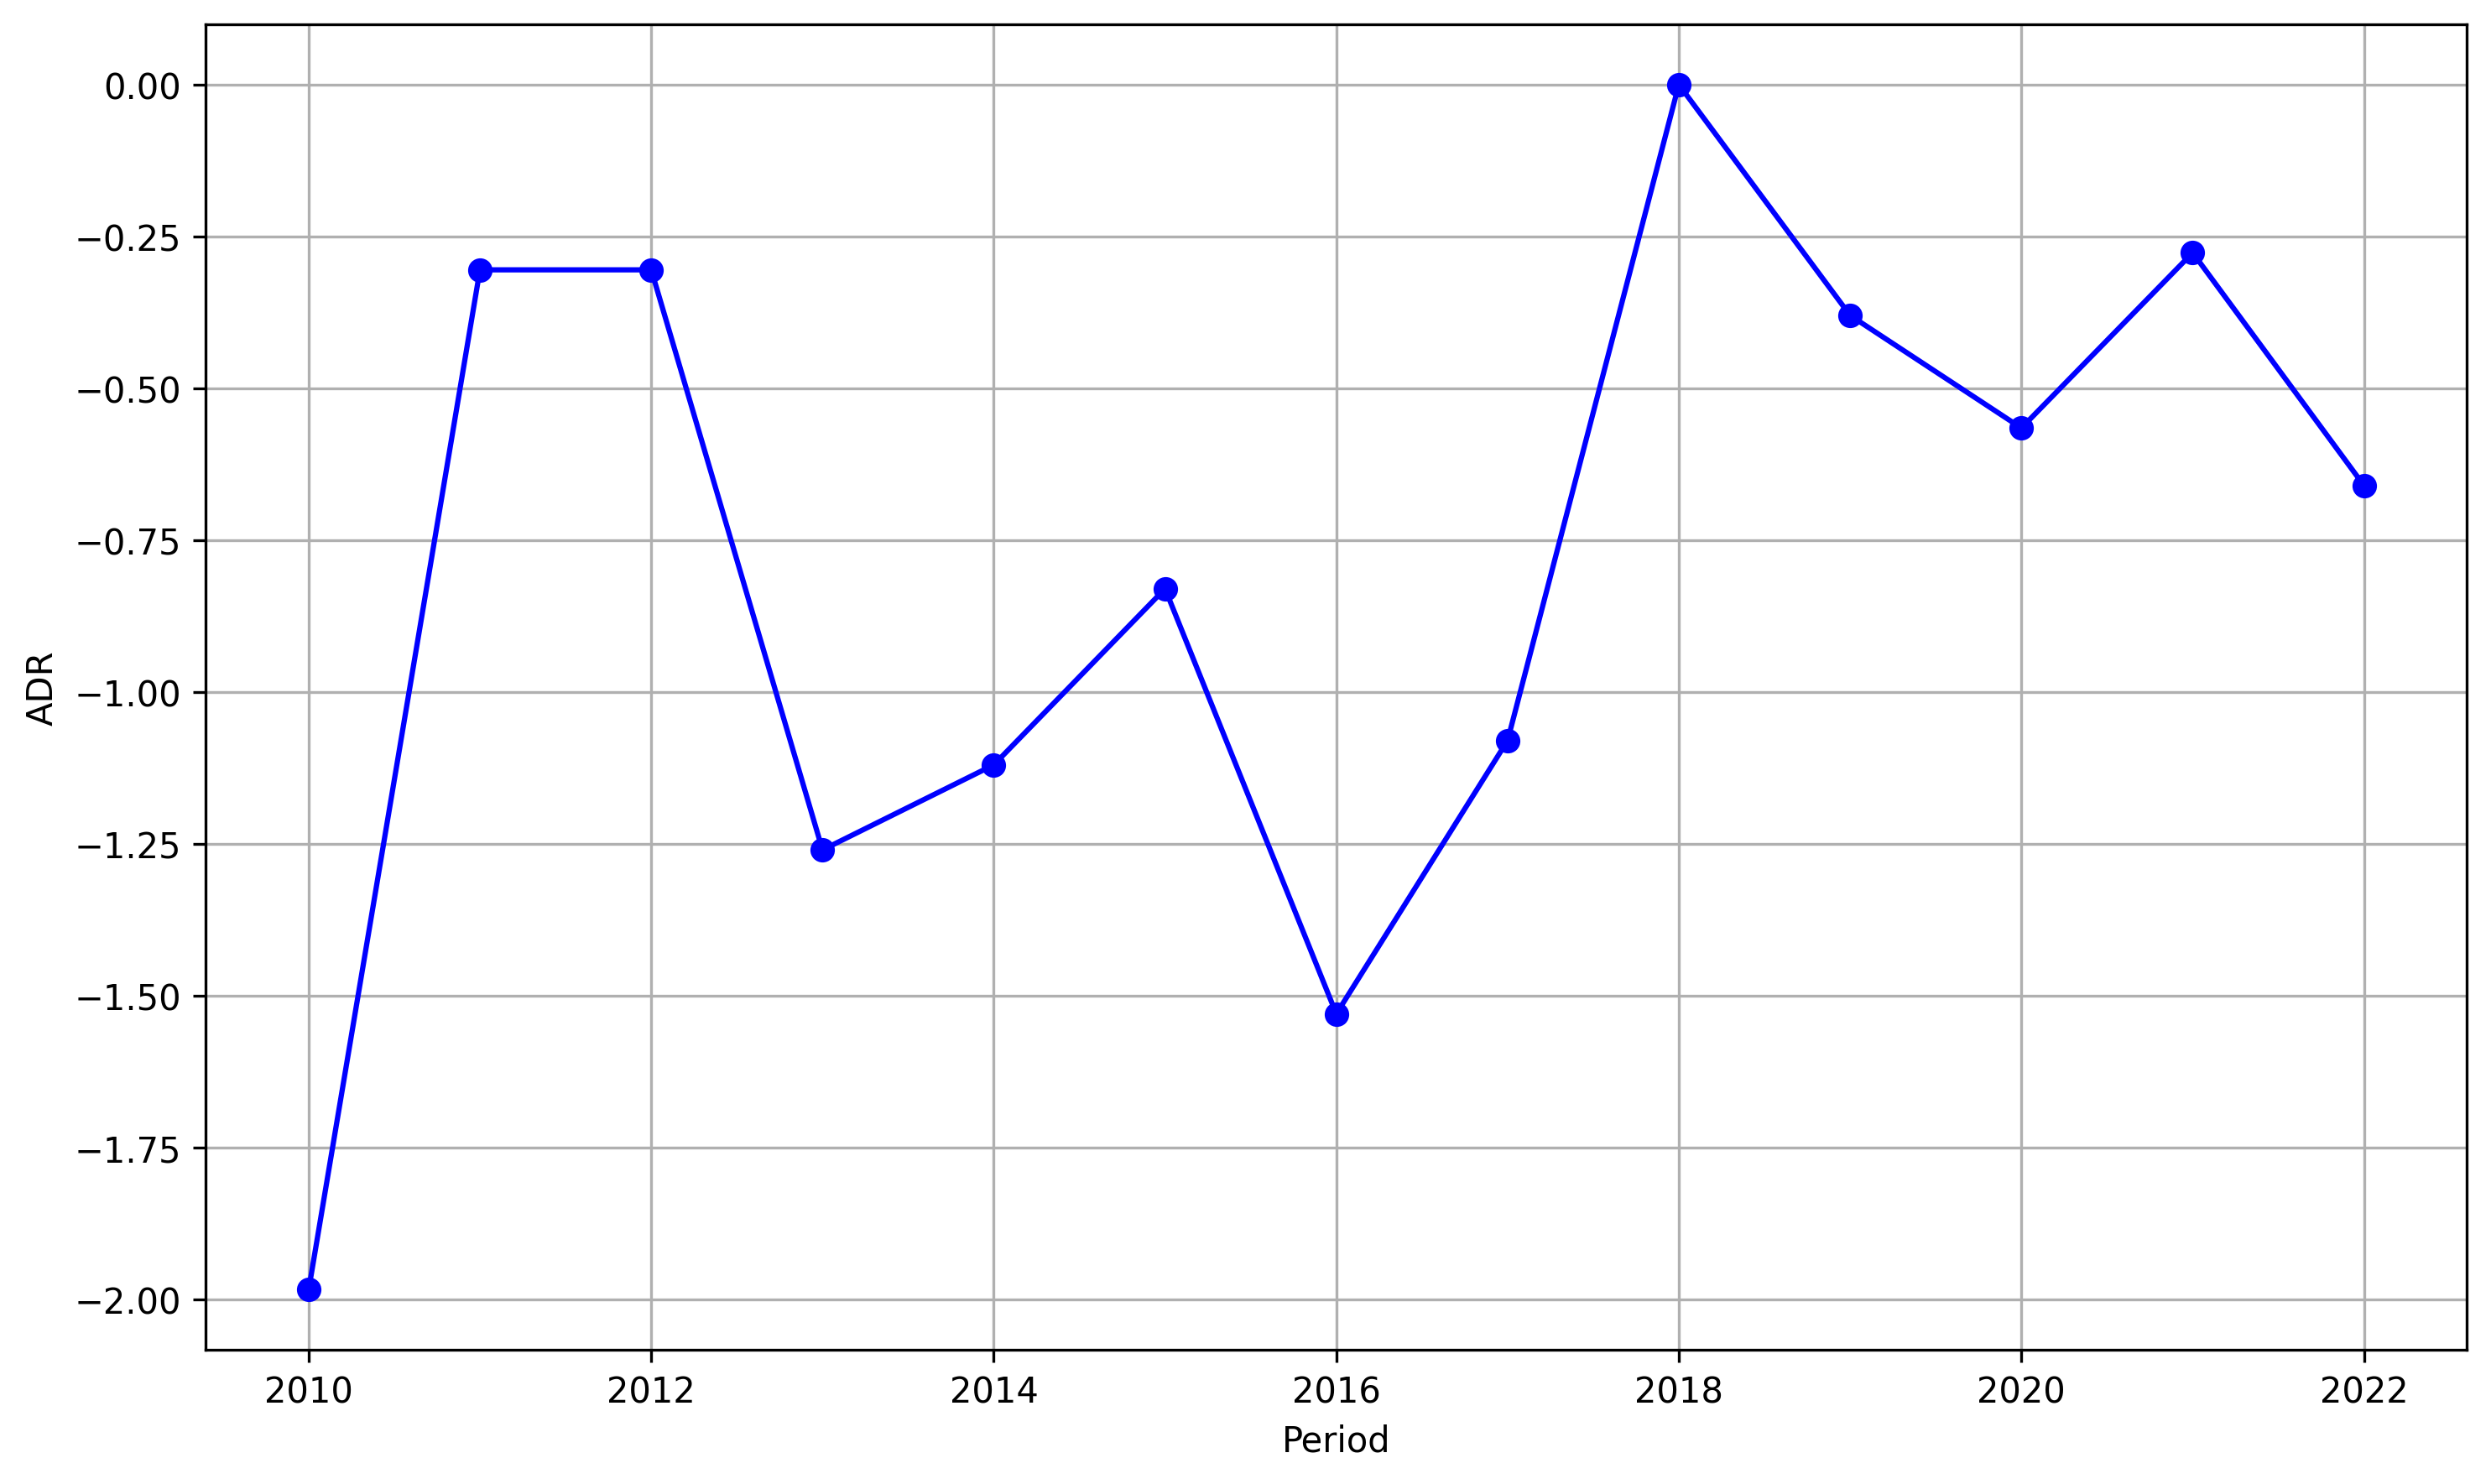

In [76]:
#TDA para el Departmento de Atlántico en Relación con el Periodo
#ADR for the Department of Atlántico in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENT'] == 'ATLÁNTICO') & (df['END_YEAR'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['END_YEAR'], df_atlantico['ADR'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 6. Gráficas TDA por Departamento (Sucre)

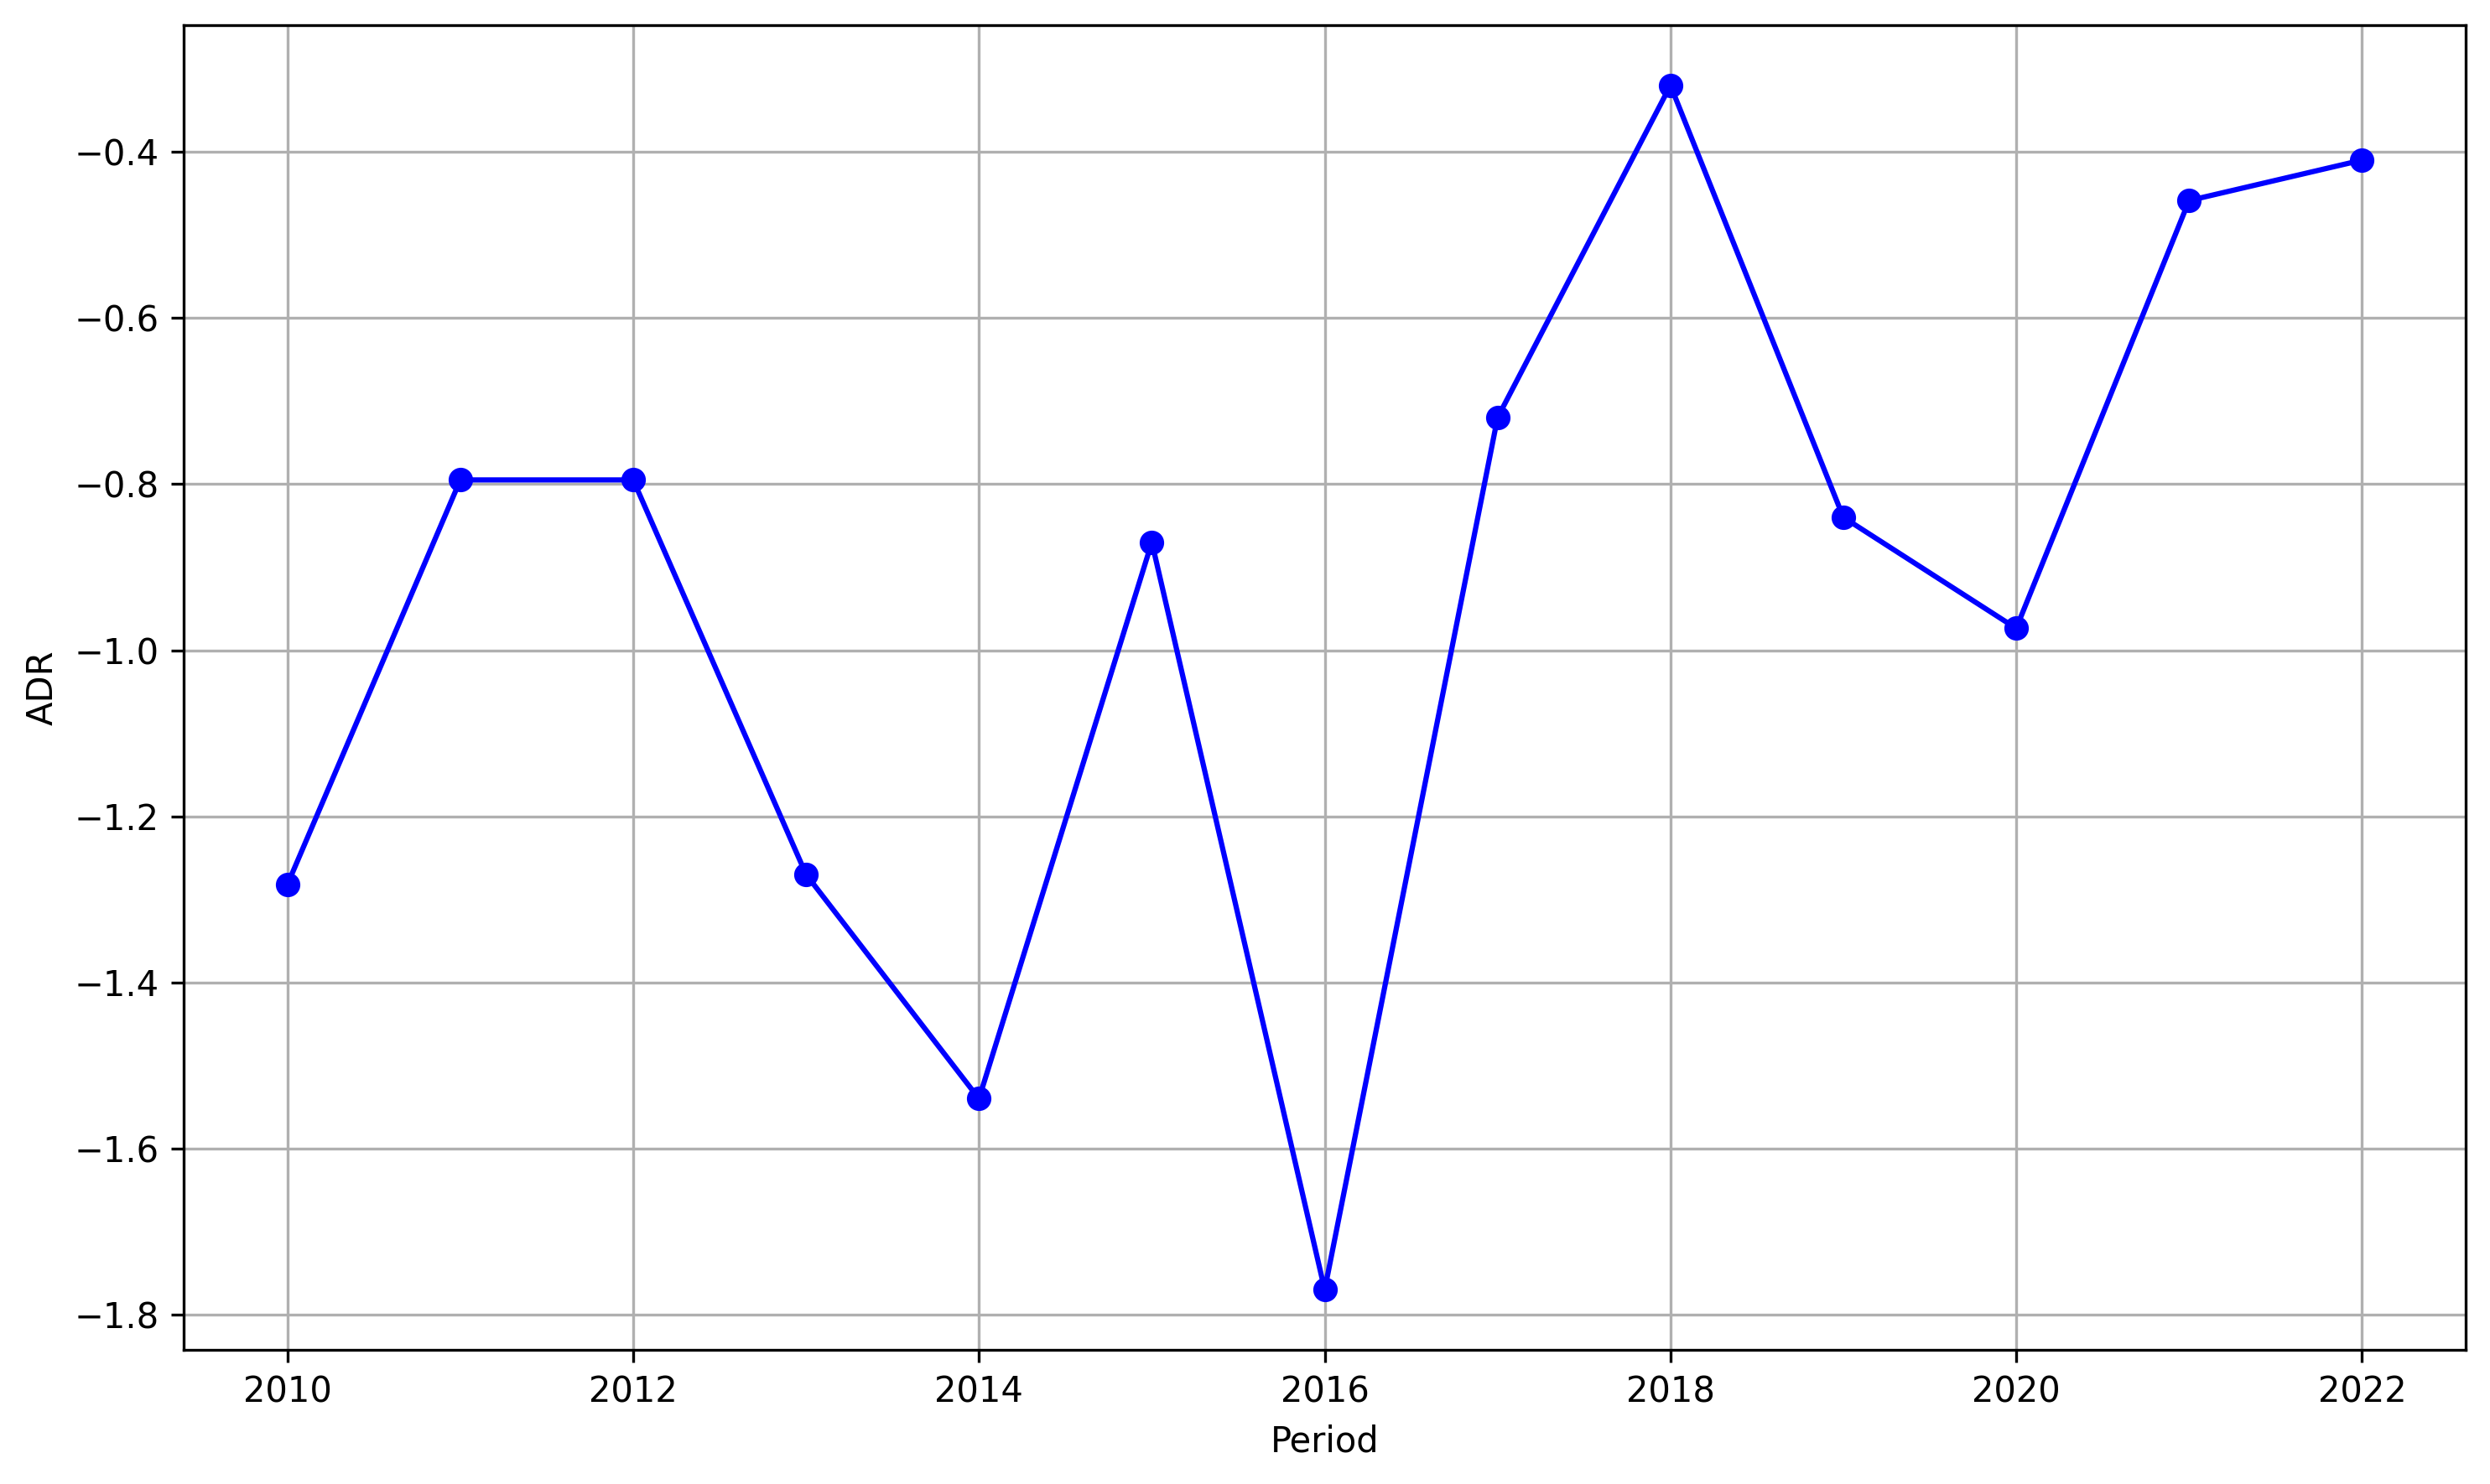

In [77]:
#TDA para el Departmento de Sucre en Relación con el Periodo
#ADR for the Department of Sucre in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENT'] == 'SUCRE') & (df['END_YEAR'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['END_YEAR'], df_atlantico['ADR'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 6. Gráficas TDA por Departamento (Santander)

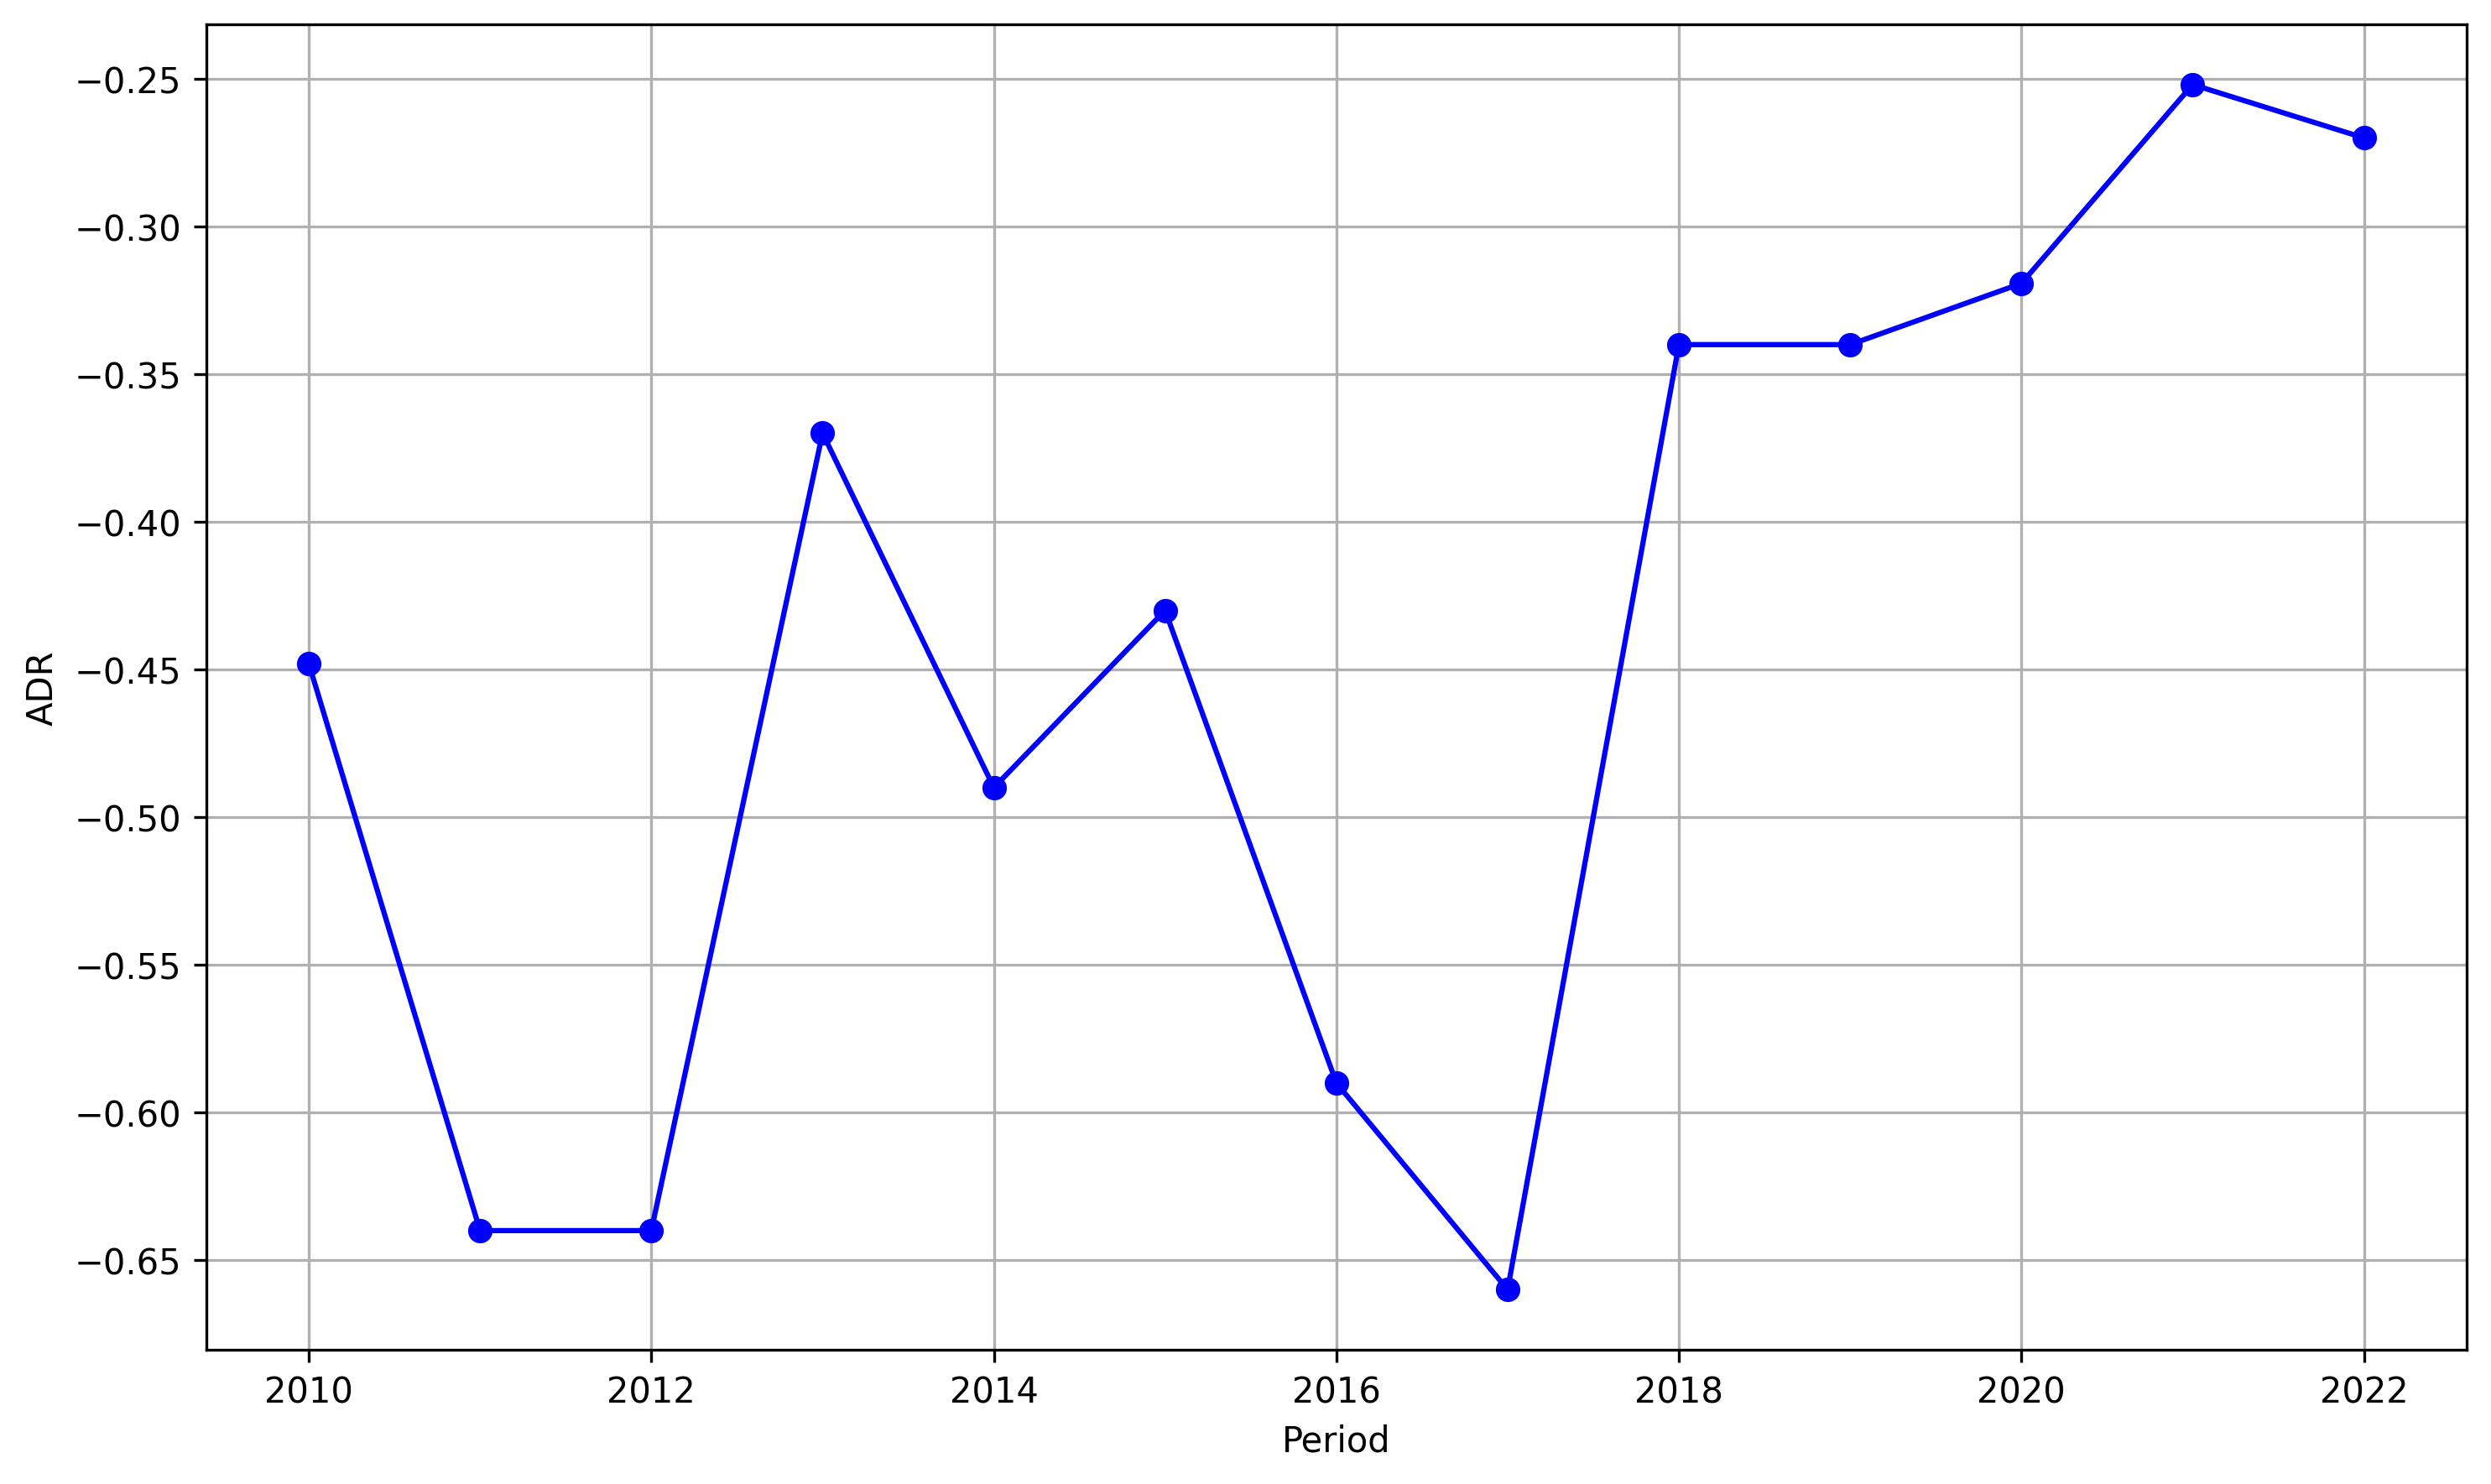

In [78]:
#TDA para el Departmento de Santander en Relación con el Periodo
#ADR for the Department of Santander in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENT'] == 'SANTANDER') & (df['END_YEAR'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['END_YEAR'], df_atlantico['ADR'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 6. Gráficas TDA por Departamento (Meta)

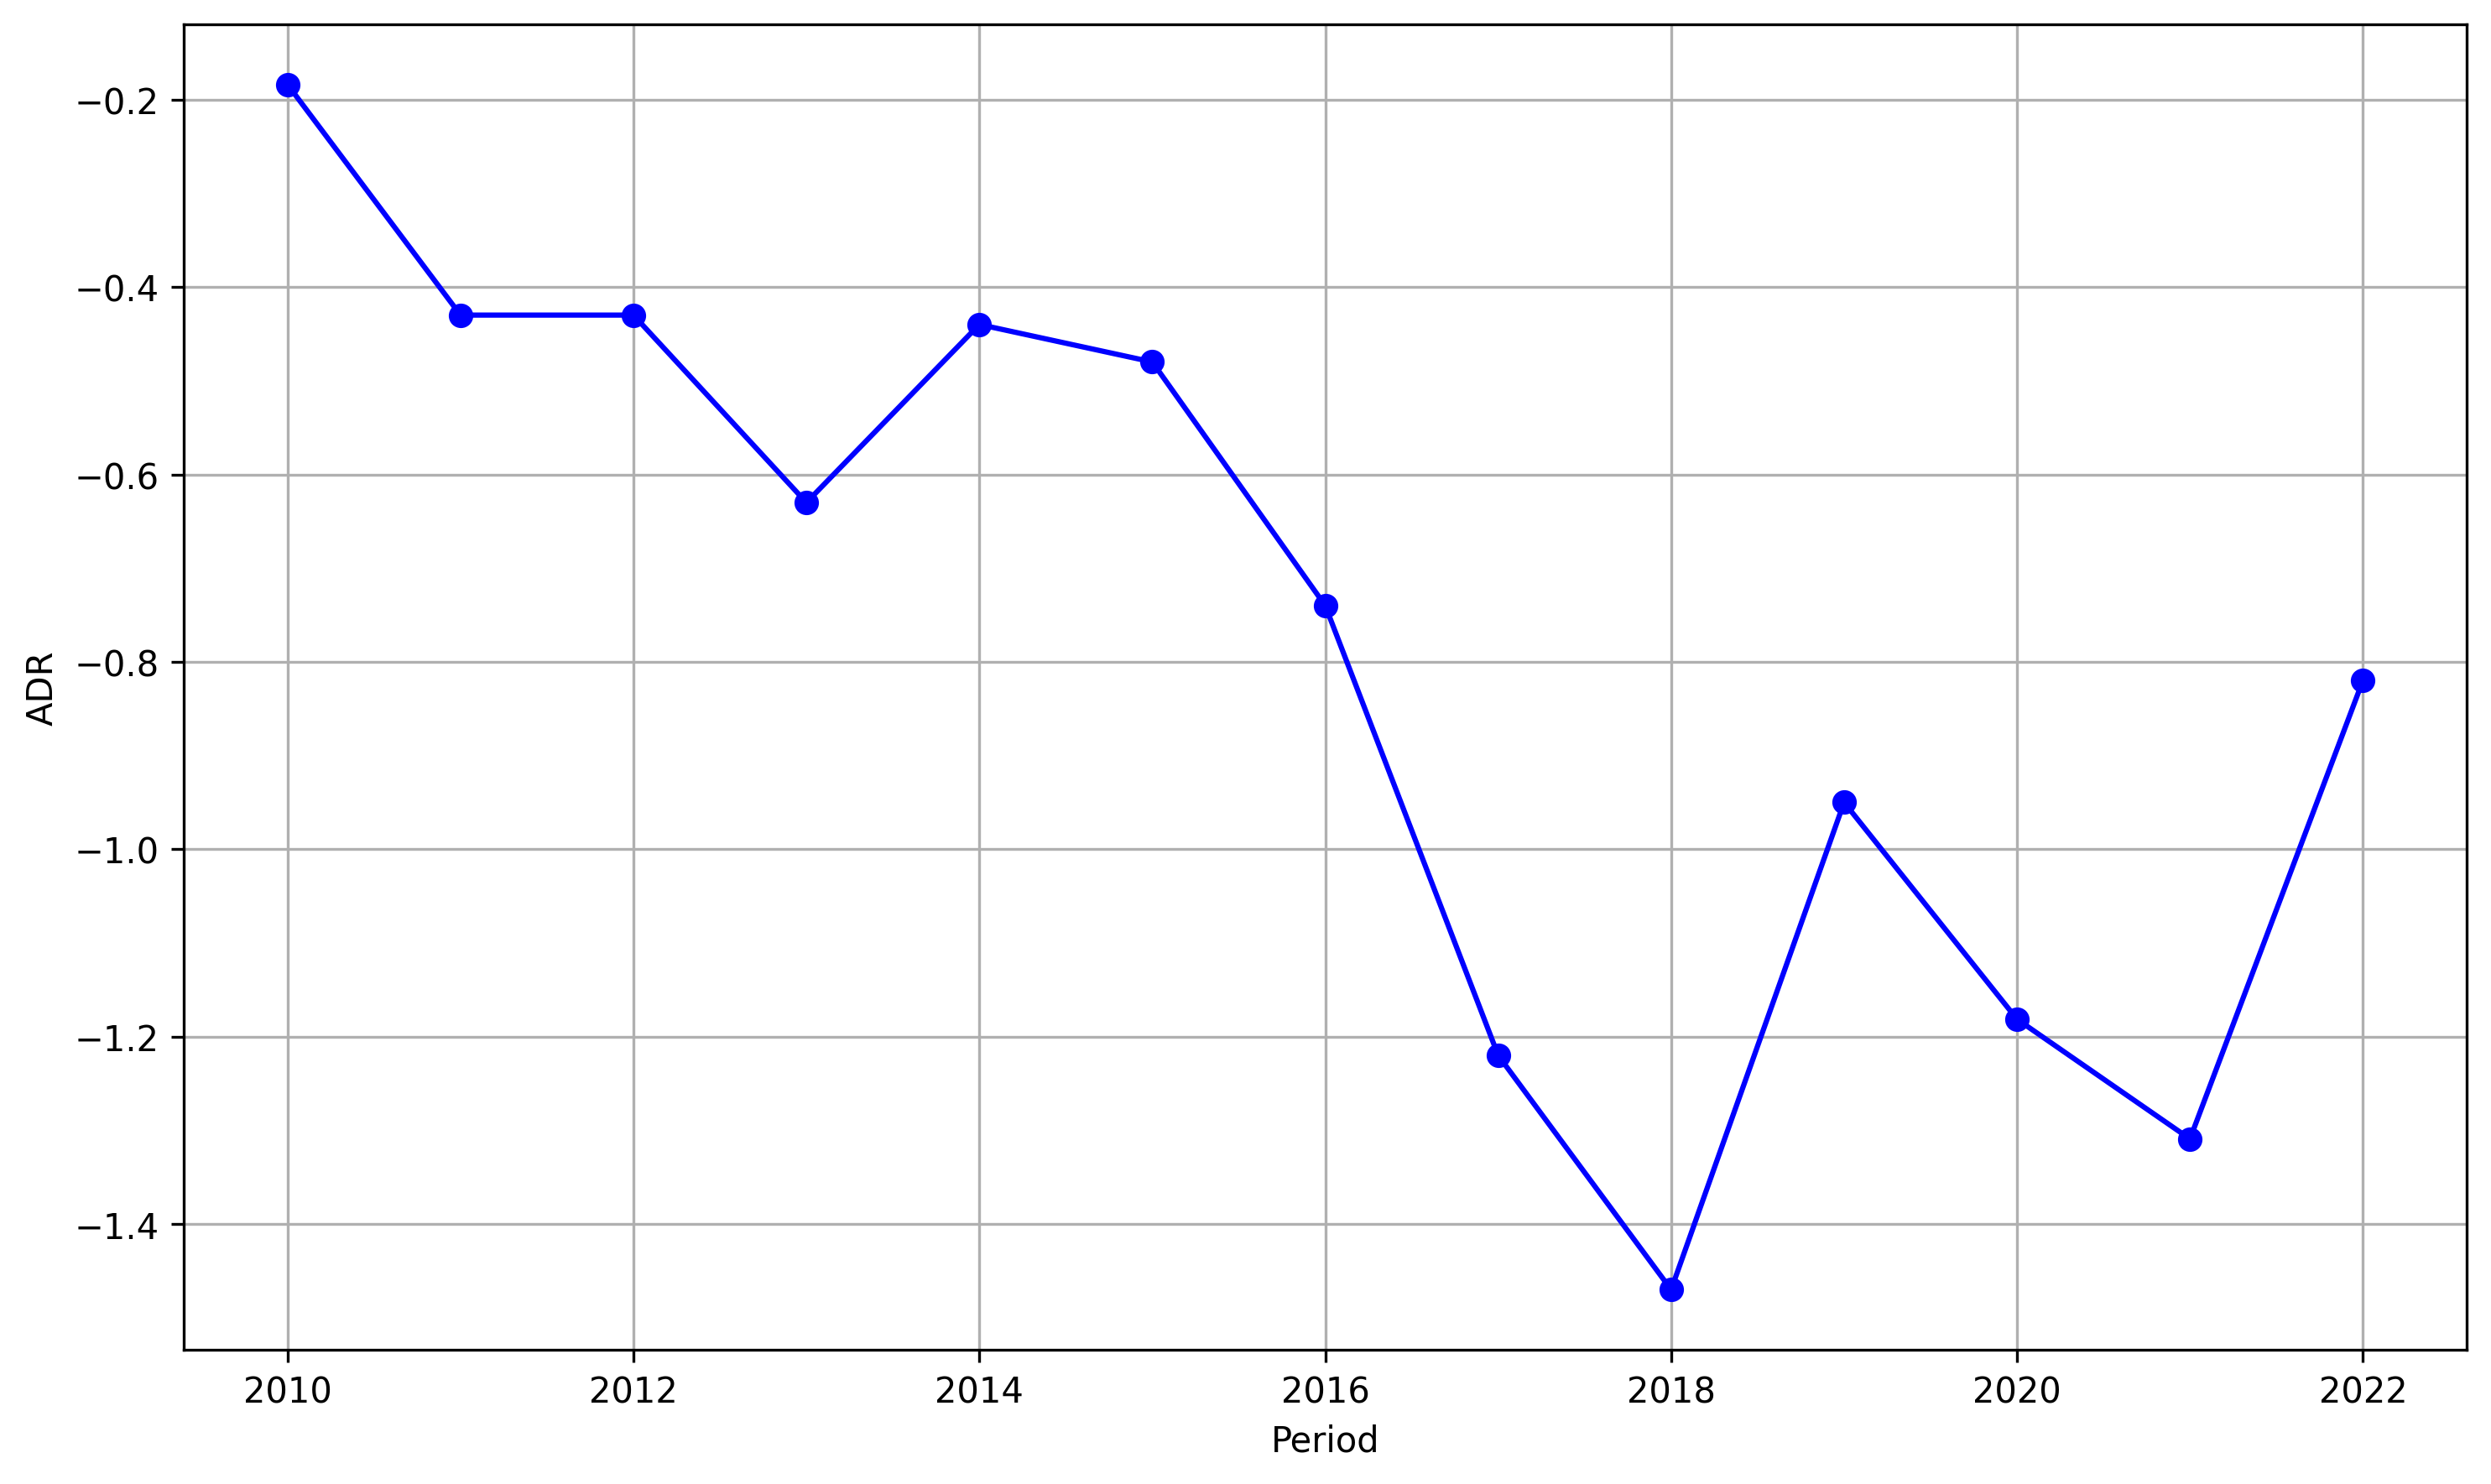

In [79]:
#TDA para el Departmento de Meta en Relación con el Periodo
#ADR for the Department of Meta in Relation to the Period

# Filtrar el DataFrame para el departamento de Atlántico y años mayores a 2009
df_atlantico = df[(df['DEPARTAMENT'] == 'META') & (df['END_YEAR'] > 2009)]

# Graficar TDA en función del PERIODO para el departamento del Atlántico
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(df_atlantico['END_YEAR'], df_atlantico['ADR'], marker='o', linestyle='-', color='b')
plt.xlabel('Period')
plt.ylabel('ADR')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 7. Descripción estadistica de la data de los departamentos con mayor DNSB/SCBE

In [80]:
# Imprimir los valores para la categoría de 'DEPARTAMENTO'con mayor realación DNSB/SCBE
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = df[df['DEPARTAMENT']  == categoria]
  print(f"Departamento: {categoria}","\n")
  print(df_filtrado.describe(),"\n")

Departamento: ATLÁNTICO 

               SFA          DA          RA         AWI       PAWI        ADR  \
count    17.000000   17.000000   17.000000   17.000000  17.000000  17.000000   
mean   4506.588235  176.941176   51.470588  159.294118   0.041176  -1.072483   
std     374.605135  226.943955   82.191938  154.522152   0.047550   0.721462   
min    4033.000000    0.000000    0.000000    0.000000   0.000000  -1.984000   
25%    4033.000000   27.000000    0.000000    0.000000   0.000000  -1.984000   
50%    4662.000000   50.000000    0.000000  106.000000   0.000000  -1.080000   
75%    4798.000000  517.000000  175.000000  345.000000   0.100000  -0.380000   
max    5018.000000  517.000000  175.000000  345.000000   0.100000   0.000000   

             NDAC        CFA   NDAC/SFA     END_YEAR  
count   17.000000  17.000000  17.000000    17.000000  
mean  -125.470588 -43.117647  -0.030202  2014.000000  
std    145.138347  25.019698   0.036512     5.049752  
min   -342.000000 -72.000000  -0.

## 8. Graficar distribución de la data de los departamentos con mayor DNSB/SCBE

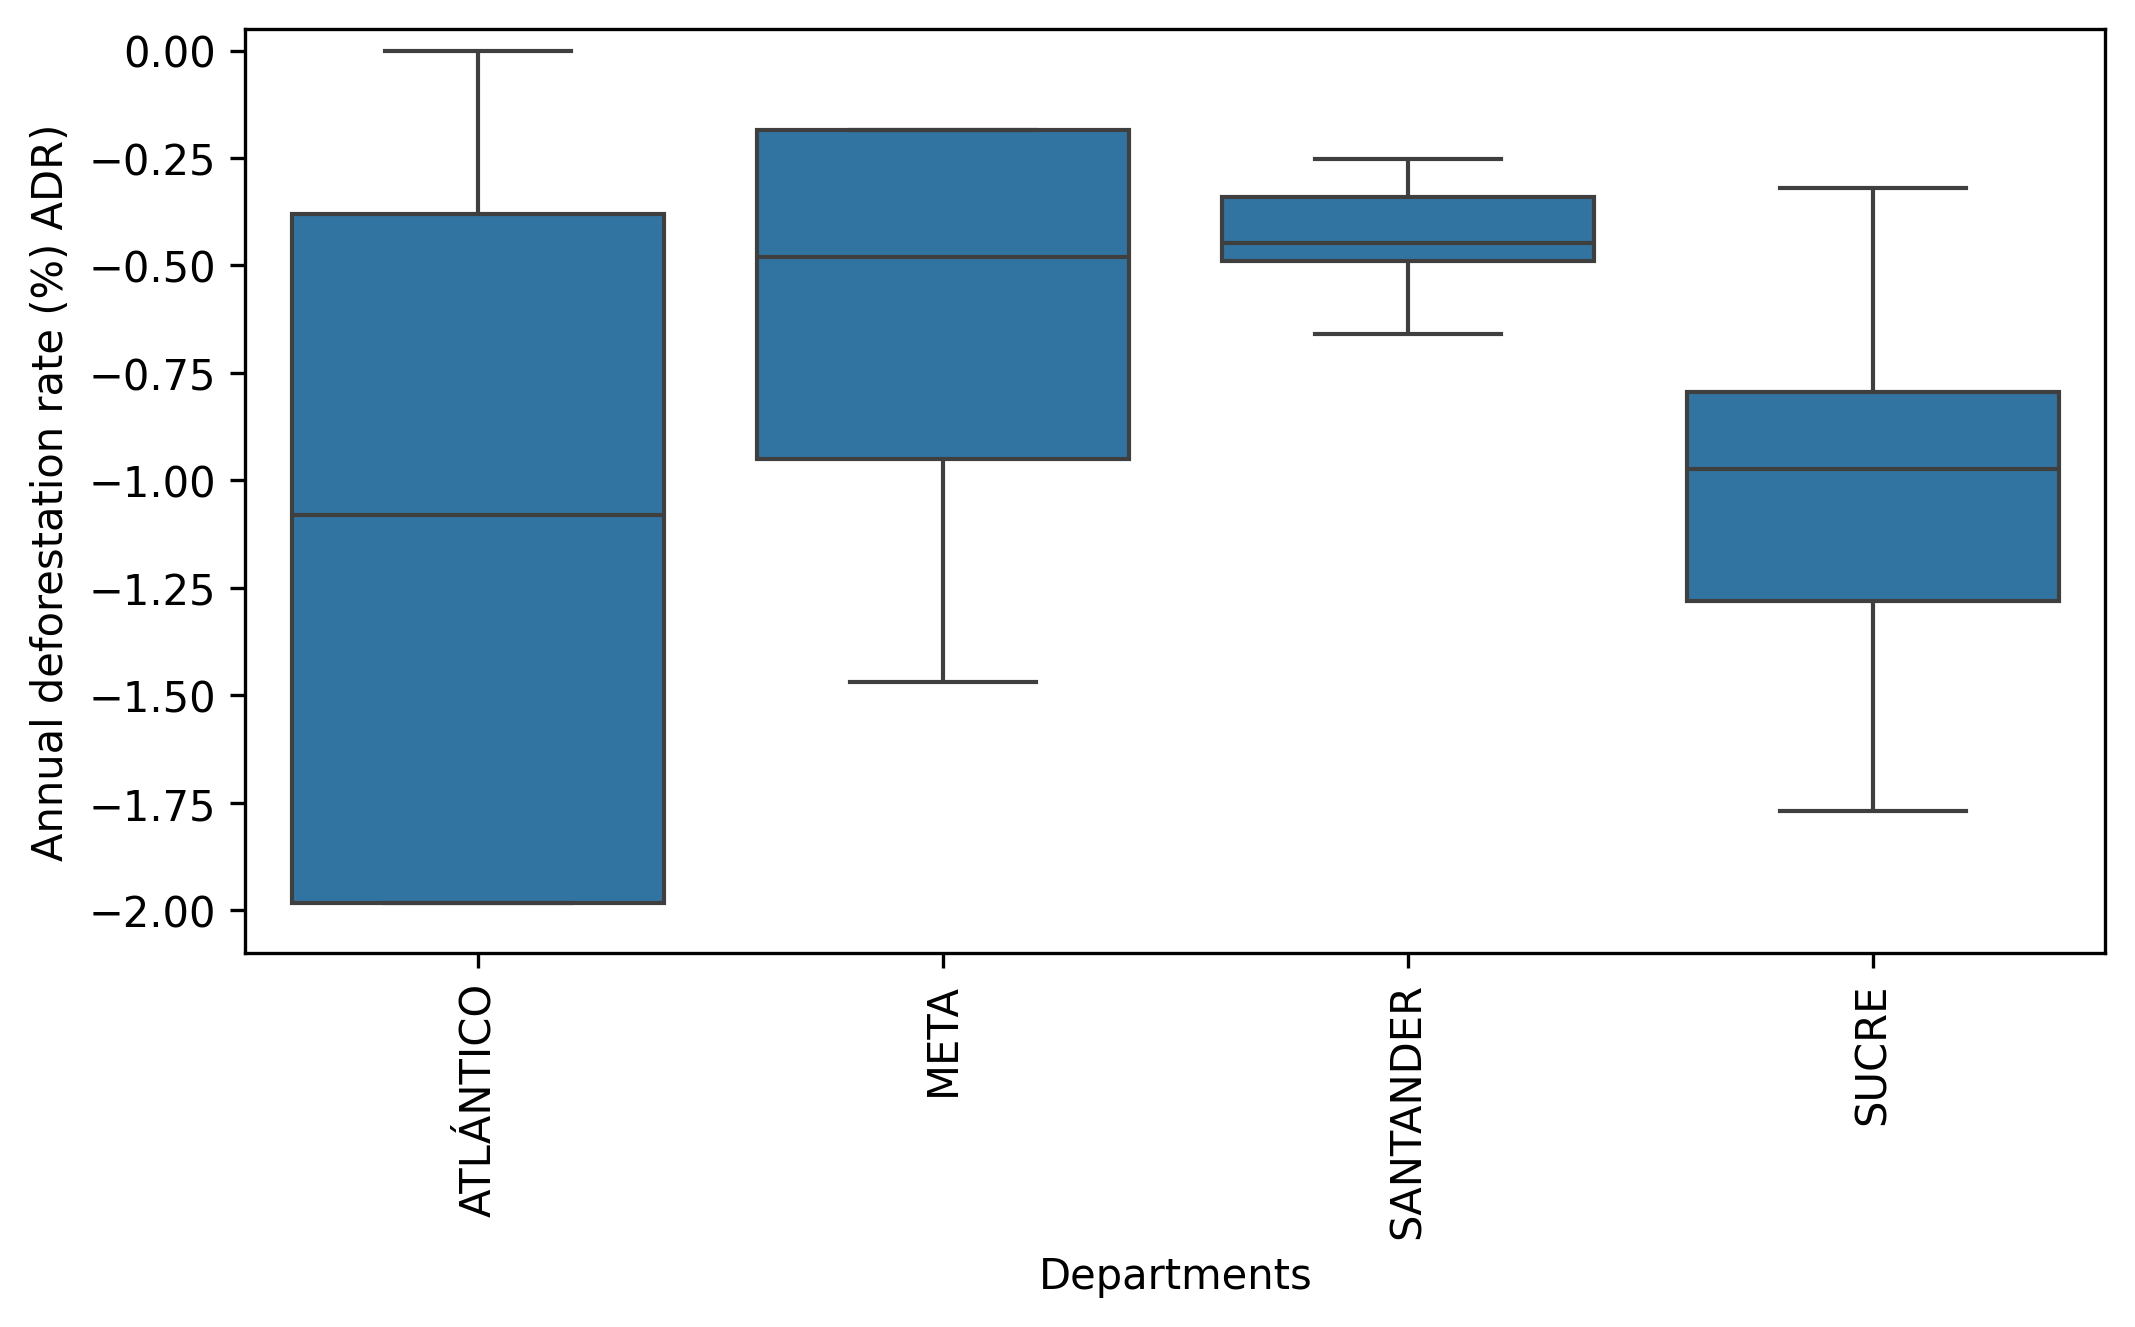

<Figure size 640x480 with 0 Axes>

In [49]:
# Especificar los cuatro departamentos con DNSB/SCBE más alta
dep_sel = ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']

# Filtrar el DataFrame original para incluir solo las categorías seleccionadas
df_filtrado = df[df['DEPARTAMENT'].isin(dep_sel)]

# Seleccionar dos categorías (columnas)
df_selected = df_filtrado[['DEPARTAMENT', 'ADR']]

plt.figure(figsize=(8, 4),dpi=300)
plt.ylim(-2.1, 0.05) # Ajustamos los límites del eje y
sns.boxplot(x='DEPARTAMENT', y='ADR', data=df_selected)
plt.xticks(rotation=90)
#plt.title('Annual deforestation rate distribution (%) TDA')
plt.xlabel('Departments')
plt.ylabel('Annual deforestation rate (%) ADR)')
plt.show()

# Guardar la figura como EPS
plt.savefig('fig1.eps', format='eps')

# Descargar el archivo
#files.download('fig1.jpeg')

## 9. Correlación de Spearman de los departamentos con mayor DNSB/SCBE

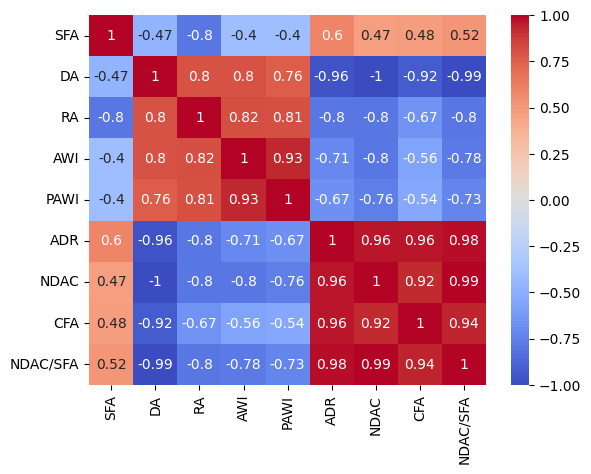

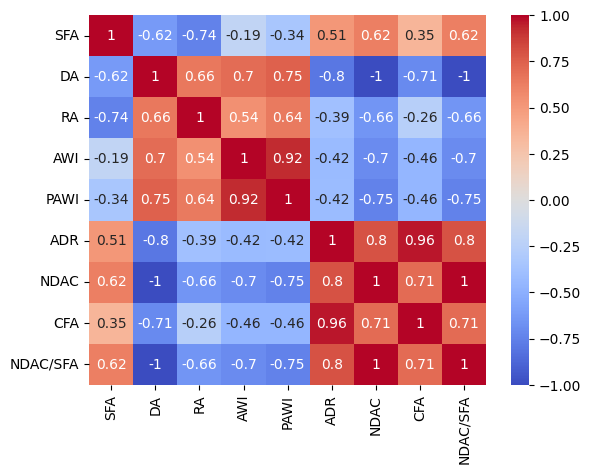

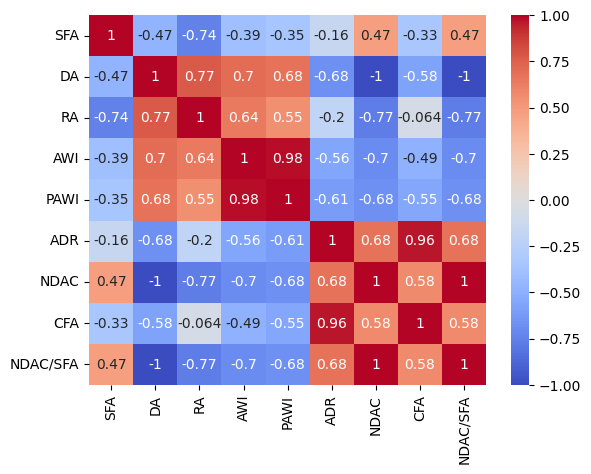

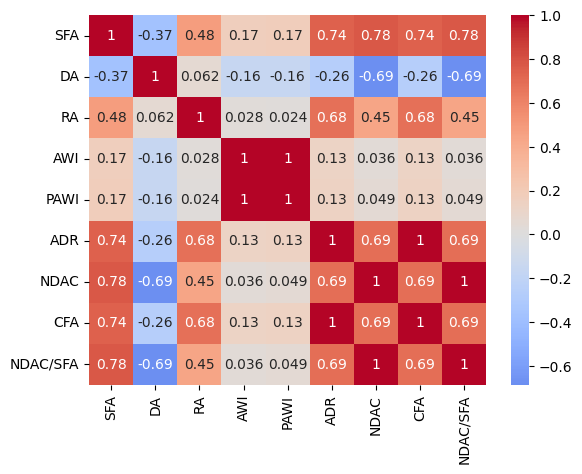

In [50]:
# Verifico la correlación entre datos para los cuatro departamentos con DNSB/SCBE más alta
caracteristicas = ['SFA', 'DA', 'RA', 'AWI', 'PAWI', 'ADR','NDAC', 'CFA', 'NDAC/SFA']

# Imprimir los valores para cada categoría de 'DEPARTAMENTO'
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = df[df['DEPARTAMENT']  == categoria]
  correlacion = df_filtrado[caracteristicas].corr(method='spearman')
  # Visualización de la matriz de correlación
  sns.heatmap(correlacion, annot=True, cmap='coolwarm', center=0)
  #plt.title(f"Departamento: {categoria}")
  plt.xticks(rotation=90)
  plt.show()
  correlacion
  #print(f"Departamento: {categoria}","\n")

In [51]:
# Departamento
df_departamento=df[df['DEPARTAMENT']=='META']
resultado = mannwhitneyu(df_departamento['ADR'], df_departamento['NDAC'], method = 'exact')
print(resultado)

MannwhitneyuResult(statistic=289.0, pvalue=8.570426247835421e-10)


## 10. Distribución de los datos de los departamentos con mayor DNSB/SCBE

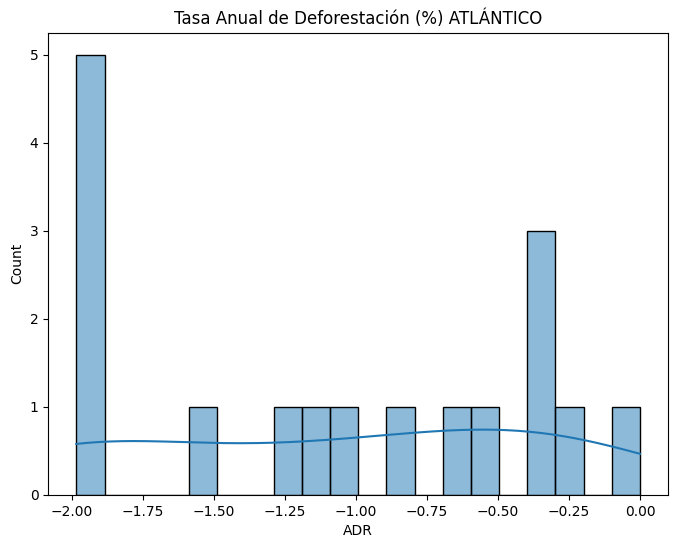

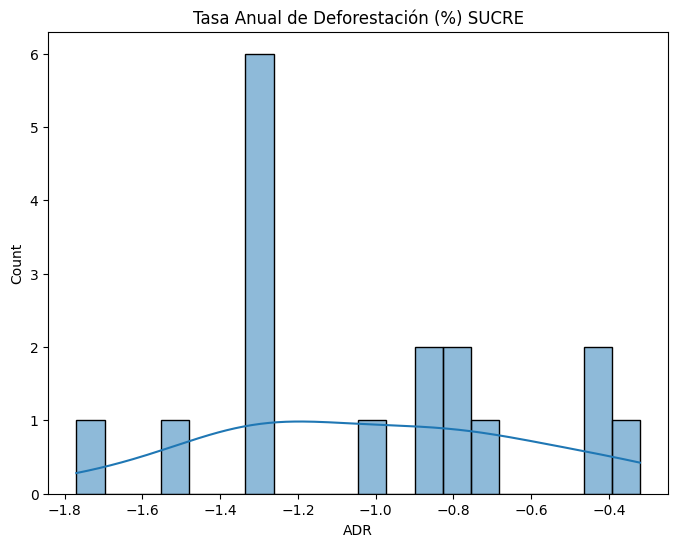

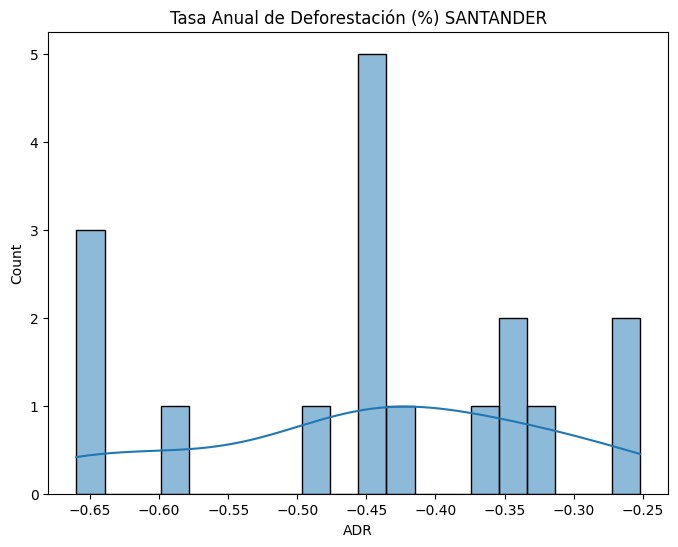

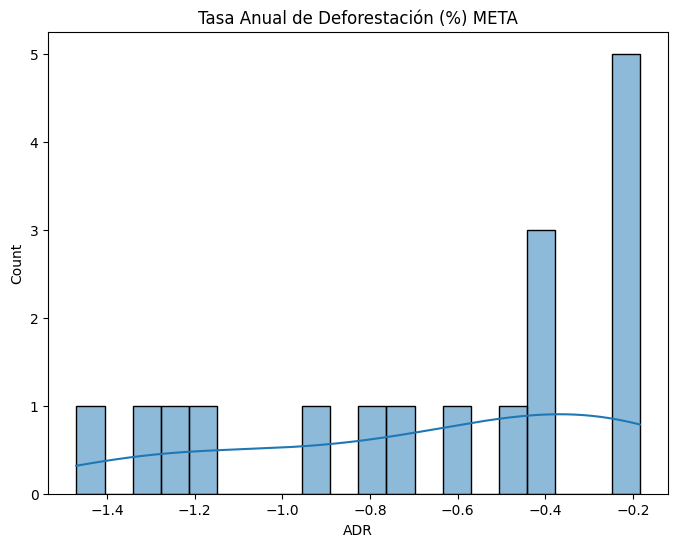

In [52]:
# Distribución de la Tasa anual de deforestación
for categoria in ['ATLÁNTICO', 'SUCRE', 'SANTANDER', 'META']:
  df_filtrado = df[df['DEPARTAMENT']  == categoria]
  plt.figure(figsize=(8, 6))
  sns.histplot(df_filtrado['ADR'], kde=True, bins=20)
  plt.title(f"Tasa Anual de Deforestación (%) {categoria}")
  plt.show()

## 11.Gráficos de dispersión entre la Tasa anual de deforestación y otras variables

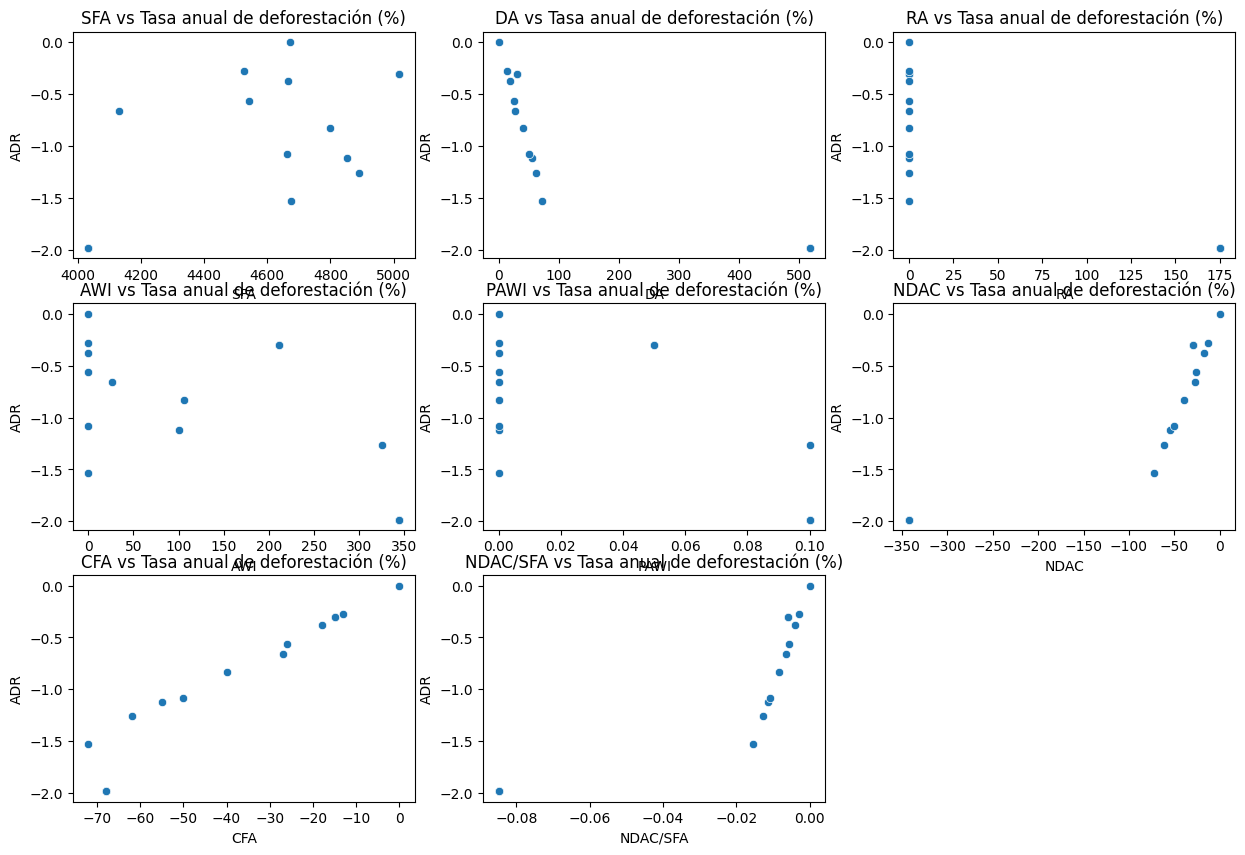

In [53]:
# Gráficos de dispersión entre la Tasa anual de deforestación y otras variables
catacteristicas = ['SFA', 'DA', 'RA', 'AWI', 'PAWI', 'NDAC', 'CFA', 'NDAC/SFA']
df_departamento=df[df['DEPARTAMENT']=='ATLÁNTICO']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(catacteristicas, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df_departamento[feature], y=df_departamento['ADR'])
    plt.title(f'{feature} vs Tasa anual de deforestación (%)')

## 12. Caracteristicas más importantes (Departamento Atlántico)
Para confirmar y cuantificar la importancia de las variables predictoras, entrenaremos un modelo de Random Forest y evaluaremos la importancia de las características.
Entrenamiento del Modelo Predictivo


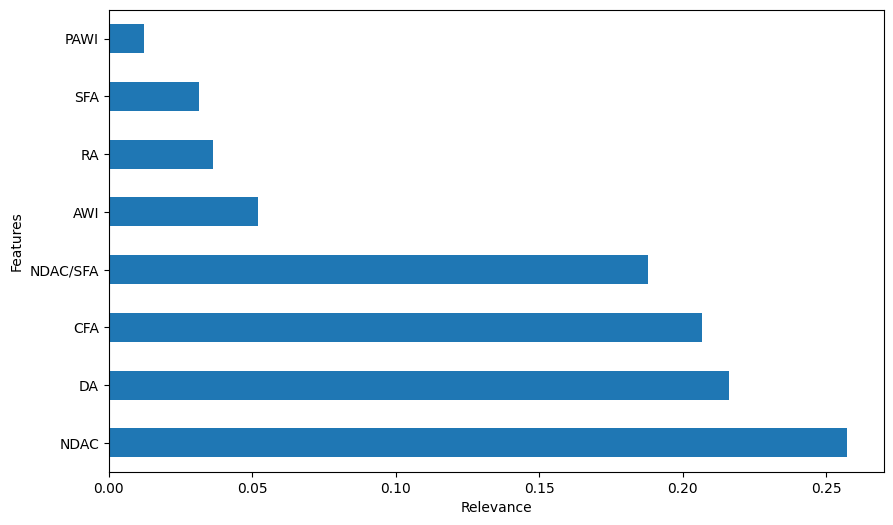

(0.06920893059385107,
 NDAC        0.257211
 DA          0.216085
 CFA         0.206879
 NDAC/SFA    0.187891
 AWI         0.051966
 RA          0.036149
 SFA         0.031395
 PAWI        0.012422
 dtype: float64)

In [54]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENT']=='ATLÁNTICO']
X = df_departamento[['SFA', 'DA', 'RA', 'AWI', 'PAWI', 'NDAC', 'CFA', 'NDAC/SFA']]
y = df_departamento['ADR']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 12. Caracteristicas más importantes (Departamento Sucre)

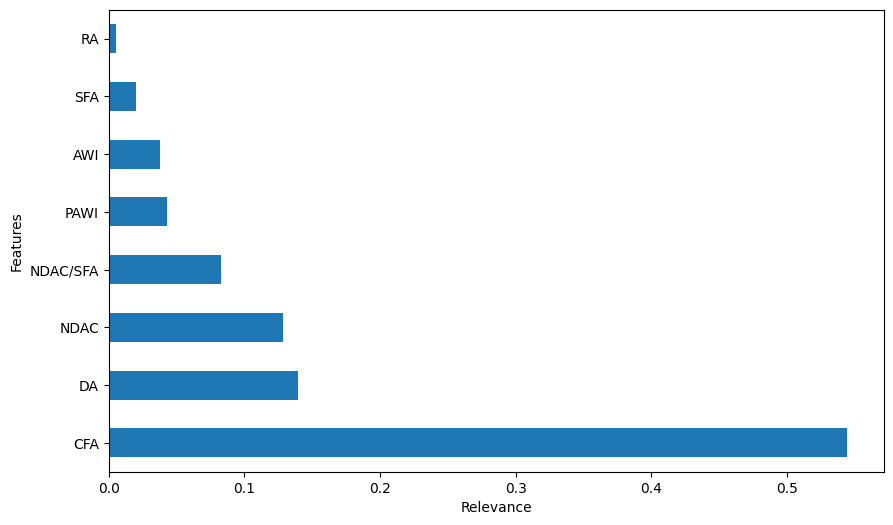

(0.09044060215288008,
 CFA         0.544002
 DA          0.139442
 NDAC        0.128322
 NDAC/SFA    0.082362
 PAWI        0.042579
 AWI         0.037606
 SFA         0.020409
 RA          0.005278
 dtype: float64)

In [55]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENT']=='SUCRE']
X = df_departamento[['SFA', 'DA', 'RA', 'AWI', 'PAWI', 'NDAC', 'CFA', 'NDAC/SFA']]
y = df_departamento['ADR']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 12. Caracteristicas más importantes (Departamento Meta)

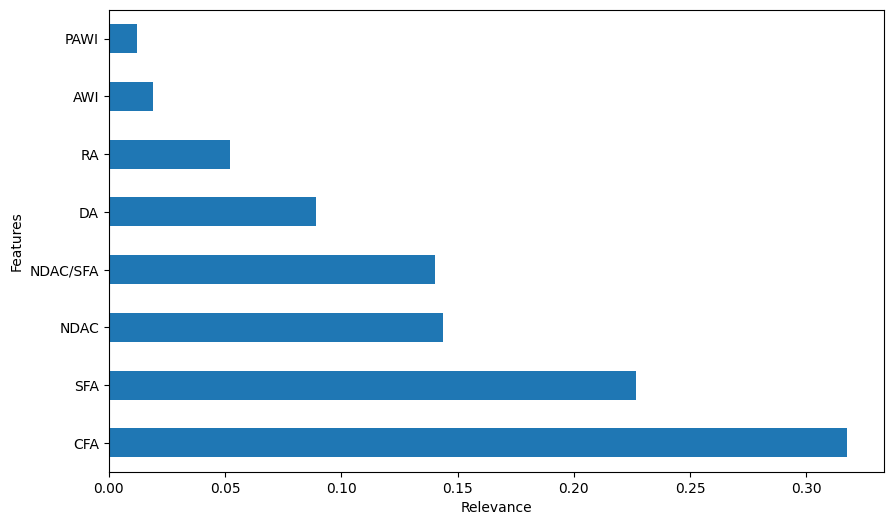

(0.07720087308166729,
 CFA         0.317364
 SFA         0.226493
 NDAC        0.143505
 NDAC/SFA    0.140300
 DA          0.089028
 RA          0.052223
 AWI         0.018863
 PAWI        0.012224
 dtype: float64)

In [56]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENT']=='META']
X = df_departamento[['SFA', 'DA', 'RA', 'AWI', 'PAWI', 'NDAC', 'CFA', 'NDAC/SFA']]
y = df_departamento['ADR']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 12. Caracteristicas más importantes (Departamento Santander)

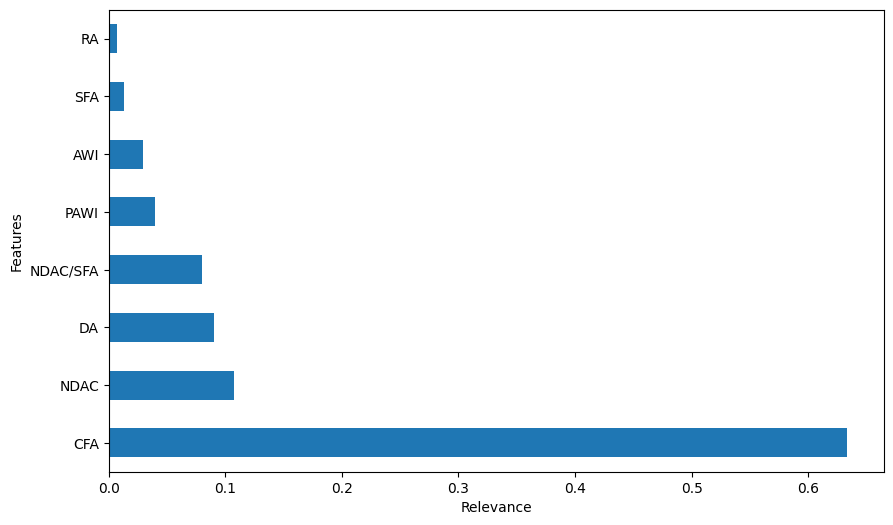

(0.022764637843406575,
 CFA         0.633216
 NDAC        0.107485
 DA          0.090179
 NDAC/SFA    0.079850
 PAWI        0.039320
 AWI         0.029701
 SFA         0.013401
 RA          0.006848
 dtype: float64)

In [57]:
# Definimos las variables predictoras y la variable objetivo

df_departamento=df[df['DEPARTAMENT']=='SANTANDER']
X = df_departamento[['SFA', 'DA', 'RA', 'AWI', 'PAWI', 'NDAC', 'CFA', 'NDAC/SFA']]
y = df_departamento['ADR']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Realizamos predicciones y evaluamos el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Importancia de las características
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Visualizamos la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
#plt.title('Importancia de las Características')
plt.xlabel('Relevance')
plt.ylabel('Features')
plt.show()
rmse, feature_importances

## 13. Modelos de predicción - Regresión (Departamento Atántico)

**División de Datos**

Divide tu conjunto de datos en datos de entrenamiento y datos de prueba

In [58]:
#### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENT']=='ATLÁNTICO']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']

# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.02
  MAE: 0.10
  R²: 0.96

Modelo: SVM
  MSE: 0.05
  MAE: 0.21
  R²: 0.88

Modelo: Regresor Random Forest
  MSE: 0.00
  MAE: 0.05
  R²: 0.99



## 13. Modelos de predicción - Regresión (Departamento Atántico) Validación cruzada

In [59]:
# Variables predictoras y variable objetivo
df_departamento = df[df['DEPARTAMENT'] == 'ATLÁNTICO']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Definir el número de folds para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir las métricas personalizadas para la validación cruzada
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# Evaluación con validación cruzada
resultados_cv = {}

for nombre, modelo in modelos.items():
    # Realizar validación cruzada con diferentes métricas
    scores_mse = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_squared_error')
    scores_mae = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_absolute_error')
    scores_r2 = cross_val_score(modelo, X, y, cv=kf, scoring='r2')

    # Guardar los resultados promedios de cada métrica
    resultados_cv[nombre] = {
        'MSE': -np.mean(scores_mse),  # Cambiar el signo ya que es negativo en sklearn
        'MAE': -np.mean(scores_mae),
        'R²': np.mean(scores_r2)
    }

# Mostrar los resultados de la validación cruzada
for nombre, result in resultados_cv.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE (Promedio CV): {result['MSE']:.2f}")
    print(f"  MAE (Promedio CV): {result['MAE']:.2f}")
    print(f"  R² (Promedio CV): {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE (Promedio CV): 0.00
  MAE (Promedio CV): 0.00
  R² (Promedio CV): 1.00

Modelo: Árbol de Decisión
  MSE (Promedio CV): 0.03
  MAE (Promedio CV): 0.11
  R² (Promedio CV): 0.76

Modelo: SVM
  MSE (Promedio CV): 0.11
  MAE (Promedio CV): 0.27
  R² (Promedio CV): 0.27

Modelo: Regresor Random Forest
  MSE (Promedio CV): 0.02
  MAE (Promedio CV): 0.10
  R² (Promedio CV): 0.91



## 13. Modelos de predicción - Regresión (Departamento Sucre)

In [60]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENT']=='SUCRE']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']


# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.01
  MAE: 0.07
  R²: 0.91

Modelo: SVM
  MSE: 0.05
  MAE: 0.17
  R²: 0.62

Modelo: Regresor Random Forest
  MSE: 0.01
  MAE: 0.07
  R²: 0.92



## 13. Modelos de predicción - Regresión (Departamento Sucre) Validación cruzada

In [81]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENT']=='SUCRE']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Definir el número de folds para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir las métricas personalizadas para la validación cruzada
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# Evaluación con validación cruzada
resultados_cv = {}

for nombre, modelo in modelos.items():
    # Realizar validación cruzada con diferentes métricas
    scores_mse = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_squared_error')
    scores_mae = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_absolute_error')
    scores_r2 = cross_val_score(modelo, X, y, cv=kf, scoring='r2')

    # Guardar los resultados promedios de cada métrica
    resultados_cv[nombre] = {
        'MSE': -np.mean(scores_mse),  # Cambiar el signo ya que es negativo en sklearn
        'MAE': -np.mean(scores_mae),
        'R²': np.mean(scores_r2)
    }

# Mostrar los resultados de la validación cruzada
for nombre, result in resultados_cv.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE (Promedio CV): {result['MSE']:.2f}")
    print(f"  MAE (Promedio CV): {result['MAE']:.2f}")
    print(f"  R² (Promedio CV): {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE (Promedio CV): 0.00
  MAE (Promedio CV): 0.00
  R² (Promedio CV): 1.00

Modelo: Árbol de Decisión
  MSE (Promedio CV): 0.01
  MAE (Promedio CV): 0.06
  R² (Promedio CV): 0.80

Modelo: SVM
  MSE (Promedio CV): 0.09
  MAE (Promedio CV): 0.23
  R² (Promedio CV): -0.16

Modelo: Regresor Random Forest
  MSE (Promedio CV): 0.02
  MAE (Promedio CV): 0.08
  R² (Promedio CV): 0.71



## 13. Modelos de predicción - Regresión (Departamento Meta)

In [61]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENT']=='META']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']

# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.02
  MAE: 0.10
  R²: 0.90

Modelo: SVM
  MSE: 0.00
  MAE: 0.05
  R²: 0.98

Modelo: Regresor Random Forest
  MSE: 0.01
  MAE: 0.07
  R²: 0.96



## 13. Modelos de predicción - Regresión (Departamento Meta) Validación cruzada

In [83]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENT']=='META']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Definir el número de folds para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir las métricas personalizadas para la validación cruzada
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# Evaluación con validación cruzada
resultados_cv = {}

for nombre, modelo in modelos.items():
    # Realizar validación cruzada con diferentes métricas
    scores_mse = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_squared_error')
    scores_mae = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_absolute_error')
    scores_r2 = cross_val_score(modelo, X, y, cv=kf, scoring='r2')

    # Guardar los resultados promedios de cada métrica
    resultados_cv[nombre] = {
        'MSE': -np.mean(scores_mse),  # Cambiar el signo ya que es negativo en sklearn
        'MAE': -np.mean(scores_mae),
        'R²': np.mean(scores_r2)
    }

# Mostrar los resultados de la validación cruzada
for nombre, result in resultados_cv.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE (Promedio CV): {result['MSE']:.2f}")
    print(f"  MAE (Promedio CV): {result['MAE']:.2f}")
    print(f"  R² (Promedio CV): {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE (Promedio CV): 0.00
  MAE (Promedio CV): 0.00
  R² (Promedio CV): 1.00

Modelo: Árbol de Decisión
  MSE (Promedio CV): 0.01
  MAE (Promedio CV): 0.09
  R² (Promedio CV): 0.91

Modelo: SVM
  MSE (Promedio CV): 0.01
  MAE (Promedio CV): 0.08
  R² (Promedio CV): 0.93

Modelo: Regresor Random Forest
  MSE (Promedio CV): 0.01
  MAE (Promedio CV): 0.07
  R² (Promedio CV): 0.89



## 13. Modelos de predicción - Regresión (Departamento Santander)

In [62]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENT']=='SANTANDER']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']


# División conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


#### Entrena cada uno de los modelos en los datos de entrenamiento.

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Entrenamiento
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)

#### Evaluación con Métricas**

#Evalúa el rendimiento de cada modelo utilizando métricas adecuadas para problemas de regresión.
#Algunas métricas comunes incluyen

resultados = {}

for nombre, modelo in modelos.items():
    # Predicciones en datos de prueba
    y_pred = modelo.predict(X_test)

    # Calcula métricas
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    resultados[nombre] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# Mostrar resultados
for nombre, result in resultados.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE: {result['MSE']:.2f}")
    print(f"  MAE: {result['MAE']:.2f}")
    print(f"  R²: {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE: 0.00
  MAE: 0.00
  R²: 1.00

Modelo: Árbol de Decisión
  MSE: 0.00
  MAE: 0.02
  R²: 0.97

Modelo: SVM
  MSE: 0.01
  MAE: 0.08
  R²: 0.61

Modelo: Regresor Random Forest
  MSE: 0.00
  MAE: 0.03
  R²: 0.93



## 13. Modelos de predicción - Regresión (Departamento Santander) Validación cruzada

In [84]:
### Variables predictoras y la variable objetivo
df_departamento=df[df['DEPARTAMENT']=='SANTANDER']
X = df_departamento[['NDAC', 'NDAC/SFA', 'CFA', 'DA']]
y = df_departamento['ADR']

# Inicialización de modelos
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(),
    'SVM': SVR(),
    'Regresor Random Forest': RandomForestRegressor()
}

# Definir el número de folds para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir las métricas personalizadas para la validación cruzada
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# Evaluación con validación cruzada
resultados_cv = {}

for nombre, modelo in modelos.items():
    # Realizar validación cruzada con diferentes métricas
    scores_mse = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_squared_error')
    scores_mae = cross_val_score(modelo, X, y, cv=kf, scoring='neg_mean_absolute_error')
    scores_r2 = cross_val_score(modelo, X, y, cv=kf, scoring='r2')

    # Guardar los resultados promedios de cada métrica
    resultados_cv[nombre] = {
        'MSE': -np.mean(scores_mse),  # Cambiar el signo ya que es negativo en sklearn
        'MAE': -np.mean(scores_mae),
        'R²': np.mean(scores_r2)
    }

# Mostrar los resultados de la validación cruzada
for nombre, result in resultados_cv.items():
    print(f"Modelo: {nombre}")
    print(f"  MSE (Promedio CV): {result['MSE']:.2f}")
    print(f"  MAE (Promedio CV): {result['MAE']:.2f}")
    print(f"  R² (Promedio CV): {result['R²']:.2f}")
    print()

Modelo: Regresión Lineal
  MSE (Promedio CV): 0.00
  MAE (Promedio CV): 0.00
  R² (Promedio CV): 1.00

Modelo: Árbol de Decisión
  MSE (Promedio CV): 0.00
  MAE (Promedio CV): 0.02
  R² (Promedio CV): 0.89

Modelo: SVM
  MSE (Promedio CV): 0.01
  MAE (Promedio CV): 0.07
  R² (Promedio CV): 0.47

Modelo: Regresor Random Forest
  MSE (Promedio CV): 0.00
  MAE (Promedio CV): 0.01
  R² (Promedio CV): 0.96

